<a href="https://colab.research.google.com/github/KavourEI/PyTorch_Exploration/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: Custom Datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

  # Check PyTorch version
torch.__version__

'2.3.1+cu121'

In [2]:
# Setup device-agnositc code
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Fri Jul 19 13:05:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts with 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting our ML projects, it's important to try things on a small scale and then increase the scale when necessar. The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one.")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak and sushi data...")
  f.write(request.content)

  # Unzip pizza, steak and sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one.
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pich a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Parth.parent.stem`
4. Since we're working with images, let's open the image withg Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/sushi/773725.jpg
Image Class : sushi
Image height : 512
Image wigth : 382


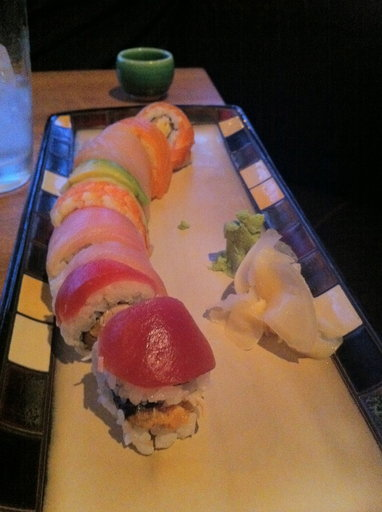

In [8]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image
random_image_path = random.choice(image_path_list)

# 3. Get the image class form path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image wigth : {img.width}")
img

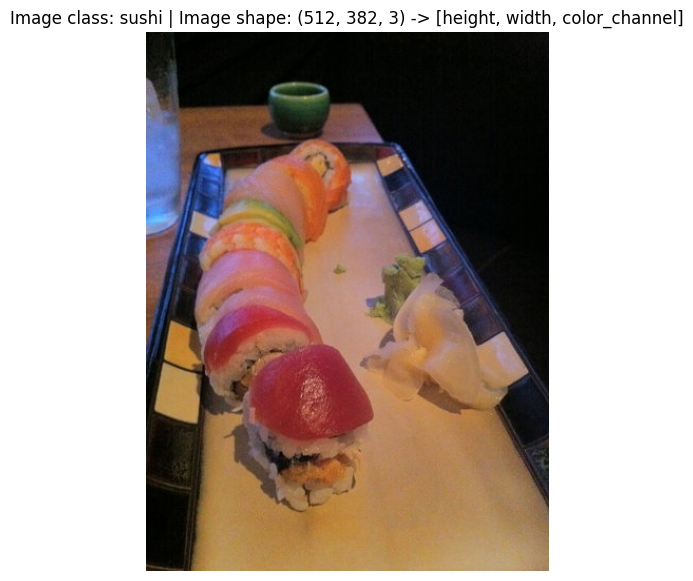

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channel]")
plt.axis(False);

## 3. Transforming Data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, a numerical representationof our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation.

In [11]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resizer our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the iamge into a troch.tensor
    transforms.ToTensor( )
])

In [12]:
data_transform(img)

tensor([[[0.0510, 0.0510, 0.0471,  ..., 0.0549, 0.0471, 0.0353],
         [0.0431, 0.0431, 0.0431,  ..., 0.0588, 0.0549, 0.0392],
         [0.0353, 0.0353, 0.0353,  ..., 0.0627, 0.0588, 0.0471],
         ...,
         [0.6510, 0.6667, 0.6824,  ..., 0.0157, 0.0157, 0.0157],
         [0.6627, 0.6784, 0.6980,  ..., 0.0235, 0.0314, 0.0392],
         [0.6549, 0.6706, 0.6941,  ..., 0.1333, 0.1490, 0.1647]],

        [[0.0510, 0.0510, 0.0471,  ..., 0.0627, 0.0549, 0.0392],
         [0.0431, 0.0431, 0.0431,  ..., 0.0667, 0.0627, 0.0471],
         [0.0392, 0.0353, 0.0353,  ..., 0.0745, 0.0667, 0.0549],
         ...,
         [0.5255, 0.5412, 0.5647,  ..., 0.0196, 0.0157, 0.0157],
         [0.5373, 0.5529, 0.5686,  ..., 0.0275, 0.0314, 0.0353],
         [0.5255, 0.5412, 0.5608,  ..., 0.1020, 0.1137, 0.1255]],

        [[0.0431, 0.0431, 0.0392,  ..., 0.0431, 0.0353, 0.0235],
         [0.0353, 0.0353, 0.0314,  ..., 0.0431, 0.0431, 0.0314],
         [0.0314, 0.0275, 0.0275,  ..., 0.0471, 0.0431, 0.

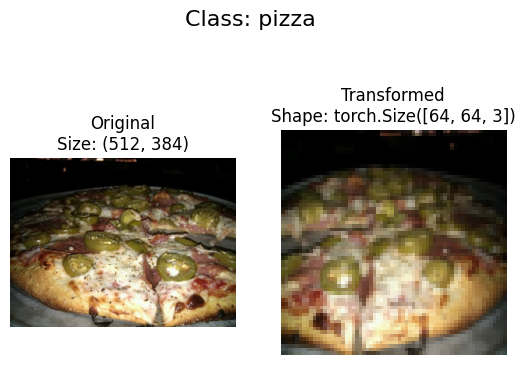

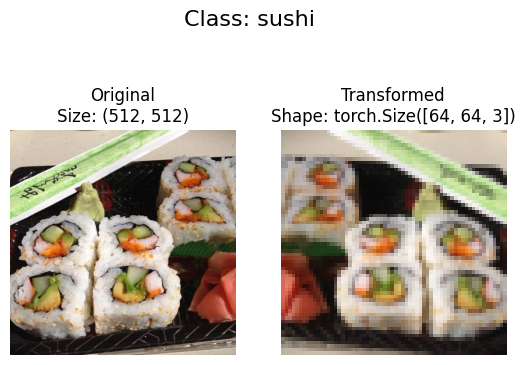

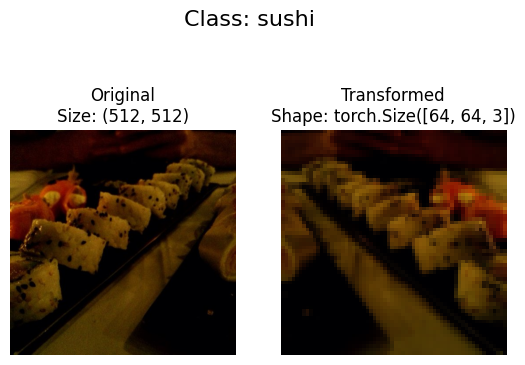

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version."""
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # With the permute we need to change the shape for matplotlib (C,H,W) ->(H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list, transform=data_transform,n=3, seed = 42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [14]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label

test_data = datasets.ImageFolder(root = test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
# Index on the train_data Dataset ot get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype : {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

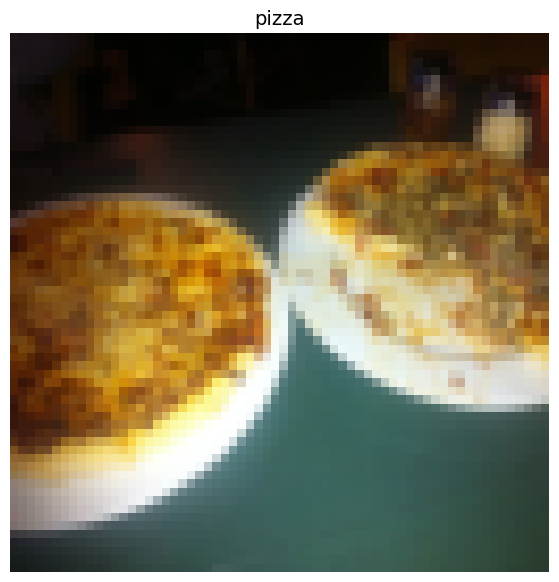

In [19]:
# Rearragne the order of dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize = 14)

### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s  into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [20]:
# Turn train and test datasets into DataLoader's

from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle = True)

test_dataloader = DataLoader(dataset= test_data,
                             batch_size = BATCH_SIZE,
                             num_workers =1,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78afc1ba3520>,
 <torch.utils.data.dataloader.DataLoader at 0x78afc1ba2a10>)

In [21]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [22]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color channels, height, width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Data with a custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-build `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almoset anythong, it doesn't mean it will work..
* Usiong a custom `Dataset` often results in us writting more code, which could be prone to errors or performance issues.

All custom dataasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.htm|#torch.utils.data.Dataset

In [23]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [24]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [25]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [26]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldm't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer number rather than string as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [27]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to simplify `DataLoader`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd lkike to transfdorm our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [28]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir:str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    # Setup transform
    self.transform = transform

    # Create classes and classe_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a fucntion to load images
  def load_image(self, index: int) -> Image.Image:
    "OPens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5.  Ovewrite __len__()
  def __len__(self) -> int:
    "Return the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    #Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx


In [29]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
    ])

test_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
    ])

In [30]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x78afc1d243d0>,
 <__main__.ImageFolderCustom at 0x78afc1d244f0>)

In [31]:
len(train_data), len(train_data_custom)

(225, 225)

In [32]:
len(test_data), len(test_data_custom)

(75, 75)

In [33]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [34]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [35]:
# Check for equality between original ImageFolrder Dataset and IamgeColderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a fucntion to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10
3. Set the random seed for reproducibility
4. Get a list of random samples indexes from the target dataset
5. Setup a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [36]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

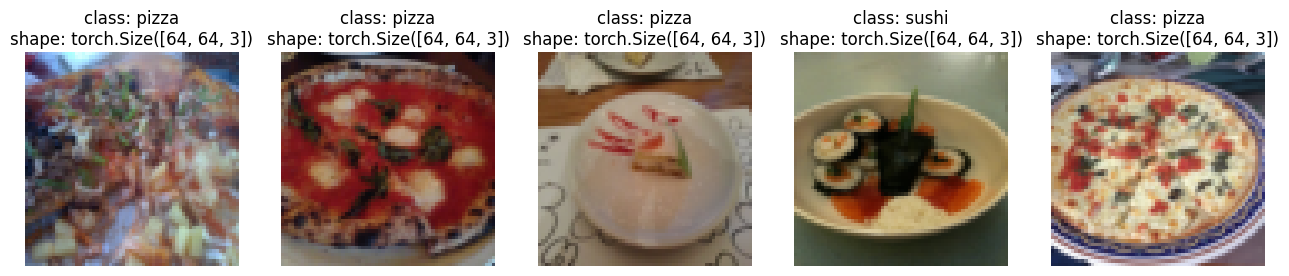

In [37]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


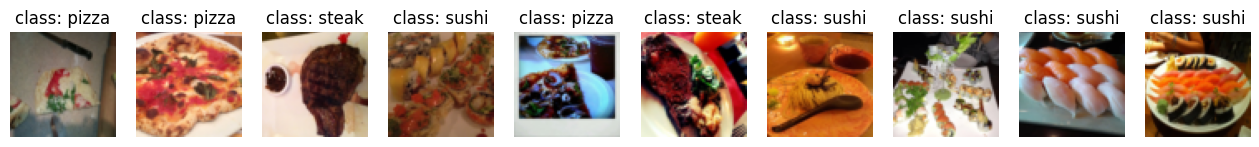

In [38]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

### 5.4 Turn custom loaded images into DataLoader's

We've got a way to turn our raw images into Dataset's (features mapped to labels or `X`'s mapped to `y`'s) through our `ImageFolderCustom` class.

Now how could we turn our custom Dataset's into DataLoader's?

If you guessed by using `torch.utils.data.DataLoader()`, you'd be right!

Because our custom `Dataset`'s subclass `torch.utils.data.Dataset`, we can use them directly with `torch.utils.data.DataLoader()`.

And we can do using very similar steps to before except this time we'll be using our custom created Dataset's.

In [39]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x78afc186b1f0>,
 <torch.utils.data.dataloader.DataLoader at 0x78afc1868fd0>)

In [40]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transforatmio to the training images.

There are many different kinds of data aumentation some of which are Rotate, Shift, Zoom, Cropping, Replacting, Shearing and many many more.

This practice hopefully result in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/


In [41]:
# Let's look at Trivial Augment - https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), #How intense the augmentation we want it to happen (An int from 0 to 31)
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [42]:
# Get all image paths

image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/1434806.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/887831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/46797.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/858157.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/175783.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2540511.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1230335.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/719108.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1600999.jpg')]

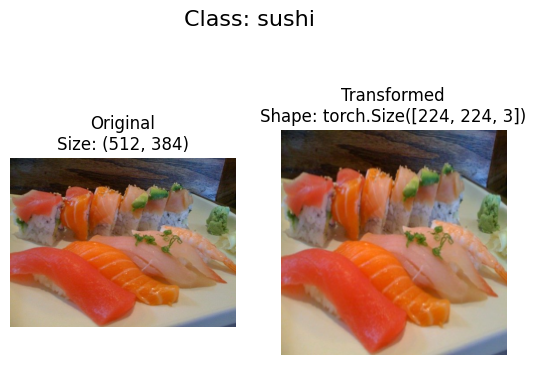

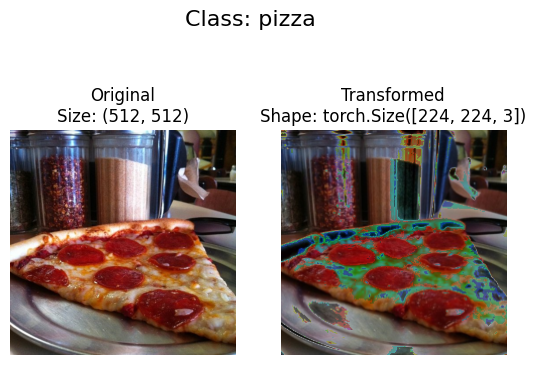

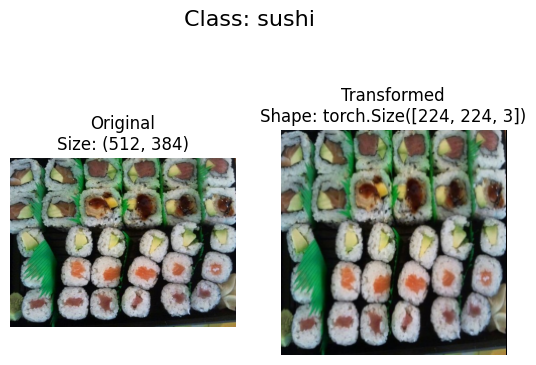

In [43]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n=3,
    seed = None
)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate the TinyVGG architecture from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

### 7.1 Create transforms and loading data for Model 0

In [48]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [51]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(
    root = train_dir,
    transform = simple_transform
)

test_data_simple = datasets.ImageFolder(
    root = test_dir,
    transform = simple_transform
)

# 2. Turn the dataset into DataLoader
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

### 7.2 Create TinnyVGG model class

In [70]:
class TinyVGG(nn.Module):
  """
  Model architecture copyiong TinyVGG from CNN Explainer
  """
  def __init__(self, input_shape:int,
               hidden_units: int,
               output_shape: int)->None:
               super().__init__()
               self.conv_block_1 = nn.Sequential(
                   nn.Conv2d(in_channels=input_shape,
                             out_channels=hidden_units,
                             kernel_size=3,
                             stride=1,
                             padding=0),
                   nn.ReLU(),
                   nn.Conv2d(in_channels=hidden_units,
                             out_channels=hidden_units,
                             kernel_size=3,
                             stride=1,
                             padding=0),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2,
                                stride=2)
               )
               self.conv_block_2 = nn.Sequential(
                   nn.Conv2d(in_channels=hidden_units,
                             out_channels=hidden_units,
                             kernel_size=3,
                             stride=1,
                             padding=0),
                   nn.ReLU(),
                   nn.Conv2d(in_channels=hidden_units,
                             out_channels=hidden_units,
                             kernel_size=3,
                             stride=1,
                             padding=0),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2,
                                stride=2)
               )
               self.classifier = nn.Sequential(
                   nn.Flatten(),
                   nn.Linear(in_features=hidden_units*13*13,
                             out_features = output_shape)
               )

  def forward(self, x):
    x = self.conv_block_1(x)
    print(x.shape)
    x=self.conv_block_2(x)
    print(x.shape)
    x = self.classifier(x)
    print(x.shape)
    return(x)


In [71]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_0 = TinyVGG(input_shape=3, #Number of color channels in our image
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [72]:
### 7.4 Try a forward pass on a single image (to test the model)

image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch = image_batch.to(device)
label_batch = label_batch.to(device)

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [73]:
# Try a forward pass
model_0(image_batch)

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `tochinfo` to get an idea of the shapes going through our model

In [79]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [78]:
from torchinfo import summary
summary(model_0, input_size=(1, 3, 64, 64))

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia